In [1]:
import torch
import flashinfer
import gc

In [2]:
def visualize_mask(mask, use_unicode=True):
    """
    Visualize a 2D or 4D boolean attention mask in ASCII.
    For 4D: (batch, head, seq, seq) -> shows each (head, seq, seq) block.
    """
    if mask.dim() == 4:
        B, H, N, M = mask.shape
        for b in range(B):
            for h in range(H):
                print(f"Batch {b}, Head {h}")
                visualize_mask(mask[b, h], use_unicode)
                print()
    elif mask.dim() == 2:
        N, M = mask.shape
        for i in range(N):
            line = ""
            for j in range(M):
                if use_unicode:
                    line += "✅" if mask[i, j] else "❌"
                else:
                    line += "." if mask[i, j] else "X"
            print(line)
    else:
        raise ValueError("Mask must be 2D or 4D boolean tensor")
    
import matplotlib.pyplot as plt

def visualize_mask_heatmap(mask, figsize=(6, 6), cmap="Greys"):
    """
    Visualize a 2D or 4D boolean attention mask as a heatmap using matplotlib.
    For 4D: (batch, head, seq, seq) -> shows a grid of subplots.
    """
    if mask.dim() == 4:
        B, H, N, M = mask.shape
        for b in range(B):
            fig, axes = plt.subplots(1, H, figsize=(figsize[0] * H, figsize[1]))
            fig.suptitle(f"Batch {b}", fontsize=14)
            for h in range(H):
                ax = axes[h] if H > 1 else axes
                ax.imshow(mask[b, h].cpu().float(), cmap=cmap, interpolation="nearest")
                ax.set_title(f"Head {h}")
                ax.axis("off")
            plt.tight_layout()
            plt.show()

    elif mask.dim() == 2:
        plt.figure(figsize=figsize)
        plt.imshow(mask.cpu().float(), cmap=cmap, interpolation="nearest")
        plt.title("Attention Mask")
        plt.axis("off")
        plt.tight_layout()
        plt.show()

    else:
        raise ValueError("Mask must be 2D or 4D boolean tensor")

In [3]:
def get_mask(q_length, kv_length, rank, batch_size):
    a = torch.zeros((q_length, kv_length), dtype=torch.bool)
    b = torch.ones((q_length, kv_length), dtype=torch.bool)

    # Upper
    for i in range(q_length):
        right = rank * q_length + i + 1
        a[i, :right] = True
    for i in range(q_length):
        start = kv_length - q_length * (rank+1) + i + 1
        # print(start)
        b[i, start:] = False
        pass
    # concat a, b 
    c = torch.cat([a, b], dim=0)
    # replicate c `batch_size` times
    d = torch.cat([c] * batch_size, dim=0)
    return d

In [9]:
def run_flash_attention(rank=0, batch_size=1, qo_len=128, kv_len=4096, num_qo_heads=32, num_kv_heads=32, head_dim=128, repeat=7, visualize_mask=False,device="cuda",return_tensors=False,verbose=False):
    def print_if_verbose(s):
        if verbose:
            print(s)
    
    print_if_verbose(f"Running flash attention with rank {rank}, batch size {batch_size}, qo_len {qo_len}, kv_len {kv_len}, num_qo_heads {num_qo_heads}, num_kv_heads {num_kv_heads}, head_dim {head_dim}, visualize_mask {visualize_mask}, device {device}, verbose {verbose}")
    q = torch.randn(qo_len * batch_size, num_qo_heads, head_dim).half().to(device)
    k = torch.randn(kv_len, num_kv_heads, head_dim).half().to(device)
    v = torch.randn(kv_len, num_kv_heads, head_dim).half().to(device)
    mask = get_mask(qo_len // 2, kv_len, rank, batch_size)
    mask = mask.to(device)
    if visualize_mask:
        visualize_mask_heatmap(mask)
    if verbose:
        print(f"q: {q.shape}, k: {k.shape}, v: {v.shape}, mask: {mask.shape}")

    start_event = torch.cuda.Event(enable_timing=True)
    end_event = torch.cuda.Event(enable_timing=True)

    compute_times = []
    for _ in range(repeat):
        start_event.record()
        o_custom = flashinfer.single_prefill_with_kv_cache(q, k, v, custom_mask=mask)
        end_event.record()

        # Waits for everything to finish running
        torch.cuda.synchronize()

        elapsed_time_ms = start_event.elapsed_time(end_event)
        compute_times.append(elapsed_time_ms)
        print_if_verbose(f"Elapsed time: {elapsed_time_ms:.2f} ms")
    
    return_values = [None, None, compute_times]
    if return_tensors:
        return_values[0] = o_custom
        return_values[1] = mask

    return return_values


Running flash attention with rank 0, batch size 2, qo_len 1024, kv_len 1024, num_qo_heads 32, num_kv_heads 32, head_dim 128, visualize_mask True, device cuda, verbose True


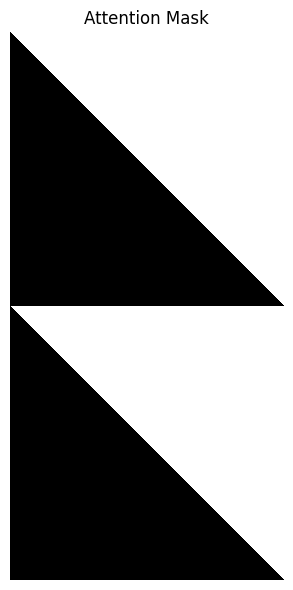

q: torch.Size([2048, 32, 128]), k: torch.Size([1024, 32, 128]), v: torch.Size([1024, 32, 128]), mask: torch.Size([2048, 1024])
Elapsed time: 0.94 ms
Elapsed time: 0.54 ms
Elapsed time: 0.40 ms
Elapsed time: 0.39 ms
Elapsed time: 0.39 ms
Elapsed time: 0.38 ms
Elapsed time: 0.38 ms


In [14]:
K = 1024
M = K * K
run_flash_attention(
    rank=0, 
    batch_size=2,
    qo_len=1 * K, 
    kv_len=1 * K,
    # kv_len=2 * K,
    num_qo_heads=32, num_kv_heads=32,
    # visualize_mask=False,
    visualize_mask=True,
    verbose=True,
)
gc.collect()
torch.cuda.empty_cache()

In [ ]:
result = []

In [15]:
cp_degree = 2
# qo_lens = [128, 256]
# qo_lens = [64, 32, 16, 8,]
qo_lens = [4, 2, 1]
for qo_len in qo_lens:
    for rank in range(cp_degree):    
        result_item = run_flash_attention(
            rank=rank, batch_size=1,
            qo_len=K * (
                qo_len // 2 // cp_degree
            ), 
            kv_len=K * qo_len,
            num_qo_heads=32, 
            num_kv_heads=8,
        )
        compute_times = result_item[2]
        median_compute_time = np.median(compute_times)
        print(f"Rank {rank} qo_len {qo_len} median compute time: {median_compute_time:.2f} ms")
        result.append({
            "cp_degree": cp_degree,
            "rank": rank,
            "qo_len": qo_len,
            "median_compute_time": median_compute_time,
            "all_compute_times": compute_times,
        })

        gc.collect()
        torch.cuda.empty_cache()

RuntimeError: CUDA error: invalid configuration argument
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
